# TC3006B
## Deep Learning
# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

### Preparations for the script
You need to install the aws cli in order for the script to work: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

Once installed, run the command 

*aws configure*

It will ask you for some keys that are hidden for security purposes. For the region put us-east-1 and for output leave it as default "json".

And for the libraries just run 

*pip install -r requirements.txt*

If everything is configured correctly you may run now the script.

## Creación del csv

### Imports

In [1]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [2]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 300  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [3]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [4]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    owner = obj.get('Owner', {}).get('DisplayName', 'Unknown')
    content_type = obj.get('ContentType', 'Unknown')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    return [
        key, last_modified, size, etag, 
        storage_class, owner, content_type,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [5]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'LastModified', 'Size', 'ETag', 
        'StorageClass', 'Owner', 'ContentType',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [6]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 300 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 300 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [23]:
# Importar las bibliotecas necesarias
import pandas as pd
import seaborn as sns
from PIL import Image

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [24]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')

# Mostrar las primeras filas para verificar
df.head()


,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,validation/8/2024-05-17-07-50-03_jpg.rf.70ed25...,2024-10-14 18:15:13+00:00,57399,"""62cc988fb61f65da5ad8b4c85b3c4edd""",STANDARD,Unknown,Unknown,640,640,133.323508,65.288408,0;0;0;0;0;0;0;1;1;0;1;2;0;0;3;6;7;12;11;26;35;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;1;3;5;14;75;...,0;0;0;0;0;0;0;0;0;0;0;1;2;0;0;3;2;8;17;35;37;9...
1,test/6/2024-05-03-01-00-03_jpg.rf.dd0a7ded477d...,2024-10-14 18:22:15+00:00,103931,"""7fe3f756c18a4991c1a3191afad09148""",STANDARD,Unknown,Unknown,1920,1080,11.843874,19.755311,361902;355467;189910;127467;84592;65388;52934;...,447079;427073;209286;122346;83575;64510;52785;...,719759;448957;177071;109442;79756;61910;49863;...
2,train/5/2024-05-19-17-50-03_jpg.rf.3dd220af852...,2024-10-14 18:13:24+00:00,165079,"""80c06ba44b5359ab8bf7aacbfcfb4eca""",STANDARD,Unknown,Unknown,1920,1080,53.036668,54.719432,606;502;1141;3374;8984;19631;34071;37317;45441...,34;58;222;1174;4160;10635;20033;31388;35405;39...,131244;100035;113121;108165;100779;83552;73707...
3,test/3/2024-04-28-01-40-03_jpg.rf.67ea99a59ca1...,2024-10-14 18:24:53+00:00,130976,"""d5e53eaa3b7f5885efa248e41d7f9ee9""",STANDARD,Unknown,Unknown,1920,1080,11.706613,12.006385,26386;88479;112758;118004;92681;78675;70200;64...,86381;174521;189793;156820;130767;118243;10791...,478266;270369;228133;202463;178280;151287;1248...
4,train/3/2024-05-21-00-10-03_jpg.rf.c0bd1adbd8f...,2024-10-14 18:10:08+00:00,123464,"""17efbdf0d797d9be1b1c8daf2c1a8852""",STANDARD,Unknown,Unknown,1920,1080,9.052002,10.931959,64399;146705;136351;134552;106666;102278;94894...,168469;287454;251969;198577;162067;133769;1079...,614723;373856;254815;202486;158984;120613;8994...


### Visualizamos csv

In [25]:
df

,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,validation/8/2024-05-17-07-50-03_jpg.rf.70ed25...,2024-10-14 18:15:13+00:00,57399,"""62cc988fb61f65da5ad8b4c85b3c4edd""",STANDARD,Unknown,Unknown,640,640,133.323508,65.288408,0;0;0;0;0;0;0;1;1;0;1;2;0;0;3;6;7;12;11;26;35;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;1;1;3;5;14;75;...,0;0;0;0;0;0;0;0;0;0;0;1;2;0;0;3;2;8;17;35;37;9...
1,test/6/2024-05-03-01-00-03_jpg.rf.dd0a7ded477d...,2024-10-14 18:22:15+00:00,103931,"""7fe3f756c18a4991c1a3191afad09148""",STANDARD,Unknown,Unknown,1920,1080,11.843874,19.755311,361902;355467;189910;127467;84592;65388;52934;...,447079;427073;209286;122346;83575;64510;52785;...,719759;448957;177071;109442;79756;61910;49863;...
2,train/5/2024-05-19-17-50-03_jpg.rf.3dd220af852...,2024-10-14 18:13:24+00:00,165079,"""80c06ba44b5359ab8bf7aacbfcfb4eca""",STANDARD,Unknown,Unknown,1920,1080,53.036668,54.719432,606;502;1141;3374;8984;19631;34071;37317;45441...,34;58;222;1174;4160;10635;20033;31388;35405;39...,131244;100035;113121;108165;100779;83552;73707...
3,test/3/2024-04-28-01-40-03_jpg.rf.67ea99a59ca1...,2024-10-14 18:24:53+00:00,130976,"""d5e53eaa3b7f5885efa248e41d7f9ee9""",STANDARD,Unknown,Unknown,1920,1080,11.706613,12.006385,26386;88479;112758;118004;92681;78675;70200;64...,86381;174521;189793;156820;130767;118243;10791...,478266;270369;228133;202463;178280;151287;1248...
4,train/3/2024-05-21-00-10-03_jpg.rf.c0bd1adbd8f...,2024-10-14 18:10:08+00:00,123464,"""17efbdf0d797d9be1b1c8daf2c1a8852""",STANDARD,Unknown,Unknown,1920,1080,9.052002,10.931959,64399;146705;136351;134552;106666;102278;94894...,168469;287454;251969;198577;162067;133769;1079...,614723;373856;254815;202486;158984;120613;8994...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,train/4/2024-05-21-18-55-04_jpg.rf.3fd59fc5a90...,2024-10-14 18:12:46+00:00,257269,"""ccc91b8f4991154116e4f2b12c365630""",STANDARD,Unknown,Unknown,1920,1080,92.590133,56.092169,40;31;40;40;75;91;104;190;262;334;425;551;720;...,0;0;2;1;0;1;2;3;4;9;34;50;97;244;528;875;1578;...,80;25;24;32;53;94;166;272;439;706;1166;1845;23...
296,train/2/2024-05-22-08-50-03_jpg.rf.092bc2d6f0b...,2024-10-14 18:09:03+00:00,266027,"""deafdc0284cff84f2c22bf54117f6aaf""",STANDARD,Unknown,Unknown,1920,1080,113.634466,50.088542,0;0;0;4;4;9;24;44;74;106;121;140;132;121;146;1...,0;0;0;0;0;0;0;0;0;0;0;0;0;1;2;3;7;10;24;28;126...,0;0;0;0;0;0;0;0;0;0;1;0;1;6;9;16;43;64;119;205...
297,train/2/2024-05-22-06-20-03_jpg.rf.a459f6e9e86...,2024-10-14 18:09:01+00:00,199465,"""eba2534f94cd4b26f03bd2801cd00c1c""",STANDARD,Unknown,Unknown,1920,1080,230.878260,25.132313,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
298,train/5/2024-05-21-06-20-03_jpg.rf.66d20978fb1...,2024-10-14 18:14:11+00:00,197031,"""07e819b9ce7a3a5d4b19999e1e538111""",STANDARD,Unknown,Unknown,1920,1080,218.213124,38.268527,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...


### Convertimos la cadena de histogramas en strings a int

In [26]:
# Definir una función para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str == '':
        return [0]*256
    return list(map(int, hist_str.split(';')))

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


,Histogram_Red,Histogram_Green,Histogram_Blue
0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
1,"[361902, 355467, 189910, 127467, 84592, 65388,...","[447079, 427073, 209286, 122346, 83575, 64510,...","[719759, 448957, 177071, 109442, 79756, 61910,..."
2,"[606, 502, 1141, 3374, 8984, 19631, 34071, 373...","[34, 58, 222, 1174, 4160, 10635, 20033, 31388,...","[131244, 100035, 113121, 108165, 100779, 83552..."
3,"[26386, 88479, 112758, 118004, 92681, 78675, 7...","[86381, 174521, 189793, 156820, 130767, 118243...","[478266, 270369, 228133, 202463, 178280, 15128..."
4,"[64399, 146705, 136351, 134552, 106666, 102278...","[168469, 287454, 251969, 198577, 162067, 13376...","[614723, 373856, 254815, 202486, 158984, 12061..."


### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

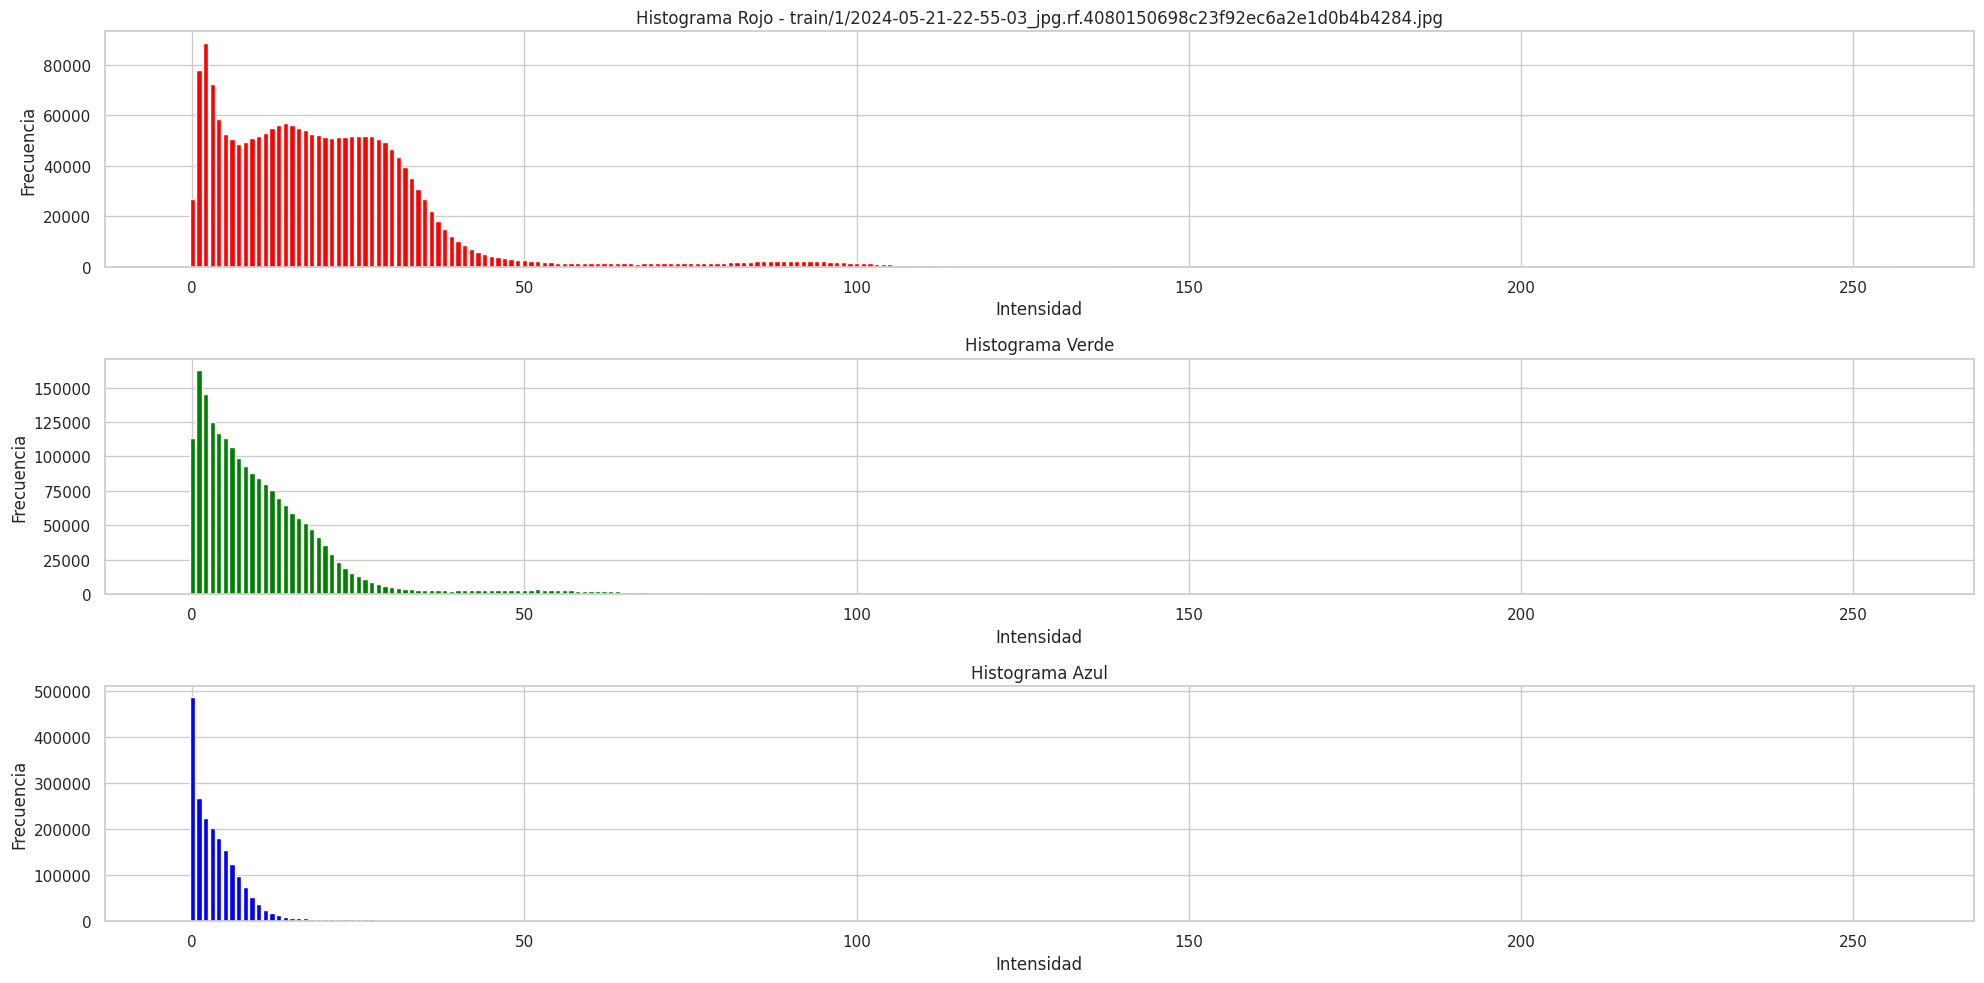

In [27]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

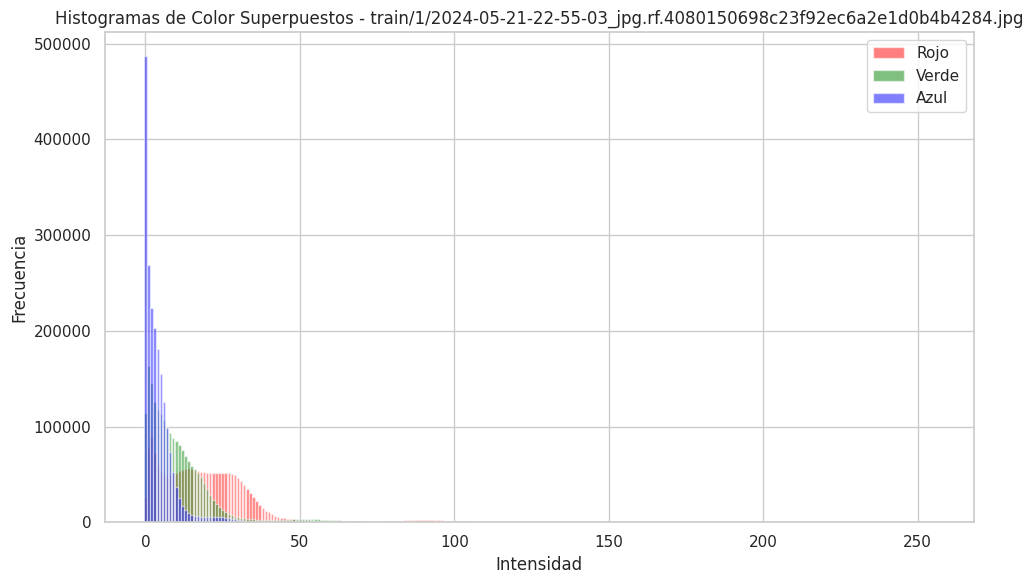

In [28]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

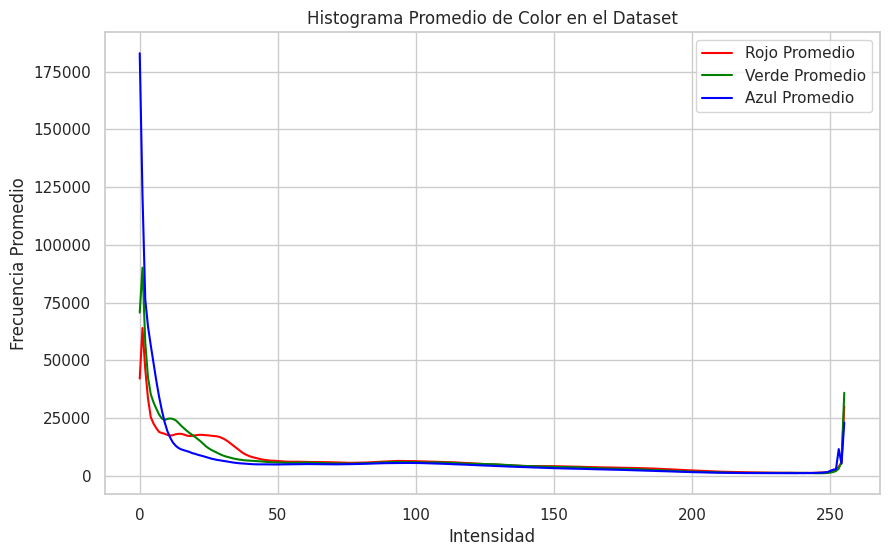

In [29]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

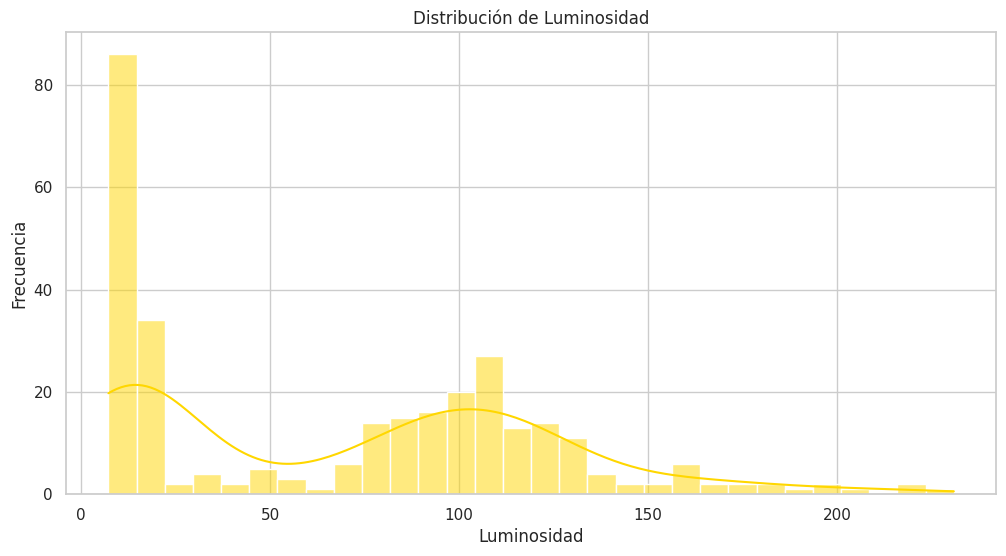

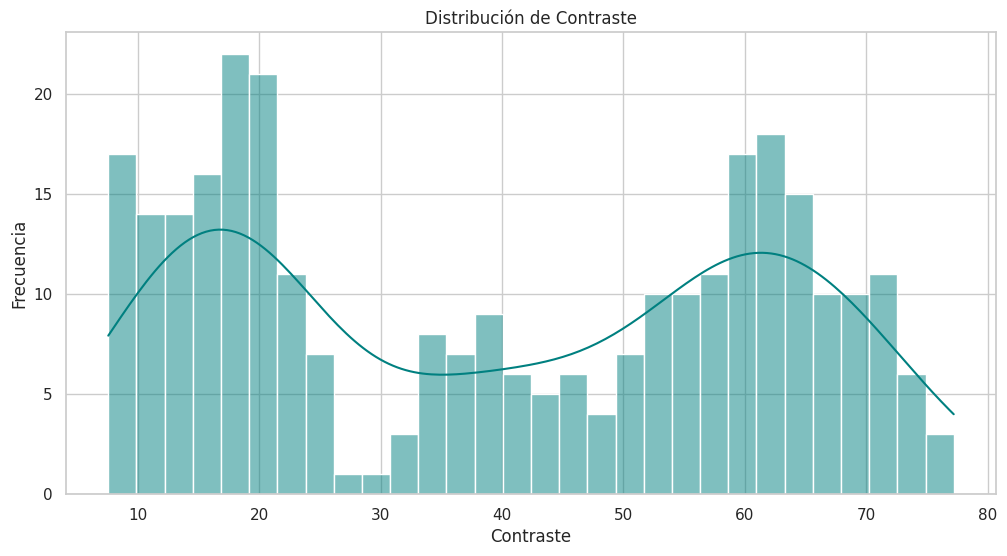

In [30]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [31]:
print(df['Luminosity'].describe())


count    300.000000
mean      69.339422
std       53.811745
min        7.228782
25%       14.025964
50%       77.530746
75%      107.970320
max      230.878260
Name: Luminosity, dtype: float64


### Dividimos el dataset en cuantiles para tener 25%, 50% y 75%

In [32]:
# Calcular los cuartiles de la luminosidad
q1 = df['Luminosity'].quantile(0.25)
q3 = df['Luminosity'].quantile(0.75)
median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")
print(f"Mediana (50%): {median_luminosity}")
print(f"Q3 (75%): {q3}")


Q1 (25%): 14.025963873215664
Mediana (50%): 77.53074580439815
Q3 (75%): 107.97031953788098


### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [33]:
# Definir los rangos de luminosidad
luminosity_low_max = q1
luminosity_average_min = q1
luminosity_average_max = q3
luminosity_high_min = q3

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 75
Número de imágenes con luminosidad promedio: 150
Número de imágenes con alta luminosidad: 75


### Función para descargar una imagen del s3 según la key

In [34]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Función para descargar 3 imágenes del s3 según las 3 categorías

In [35]:
# Función para seleccionar una imagen al azar de un DataFrame
def select_random_image(df_category):
    if df_category.empty:
        print("No hay imágenes en esta categoría.")
        return None
    return df_category.sample(n=1).iloc[0]

# Seleccionar una imagen de cada categoría
image_low = select_random_image(low_luminosity_df)
image_average = select_random_image(average_luminosity_df)
image_high = select_random_image(high_luminosity_df)


### Descargamos las 3 imágenes

In [36]:
# Inicializar el cliente de S3
s3 = boto3.client('s3')

# Descargar las imágenes
image_low_pil = download_image_from_s3(s3, BUCKET_NAME, image_low['Key']) if image_low is not None else None
image_average_pil = download_image_from_s3(s3, BUCKET_NAME, image_average['Key']) if image_average is not None else None
image_high_pil = download_image_from_s3(s3, BUCKET_NAME, image_high['Key']) if image_high is not None else None


### Mostramos las 3 imágenes, una para cada nivel de luminosidad

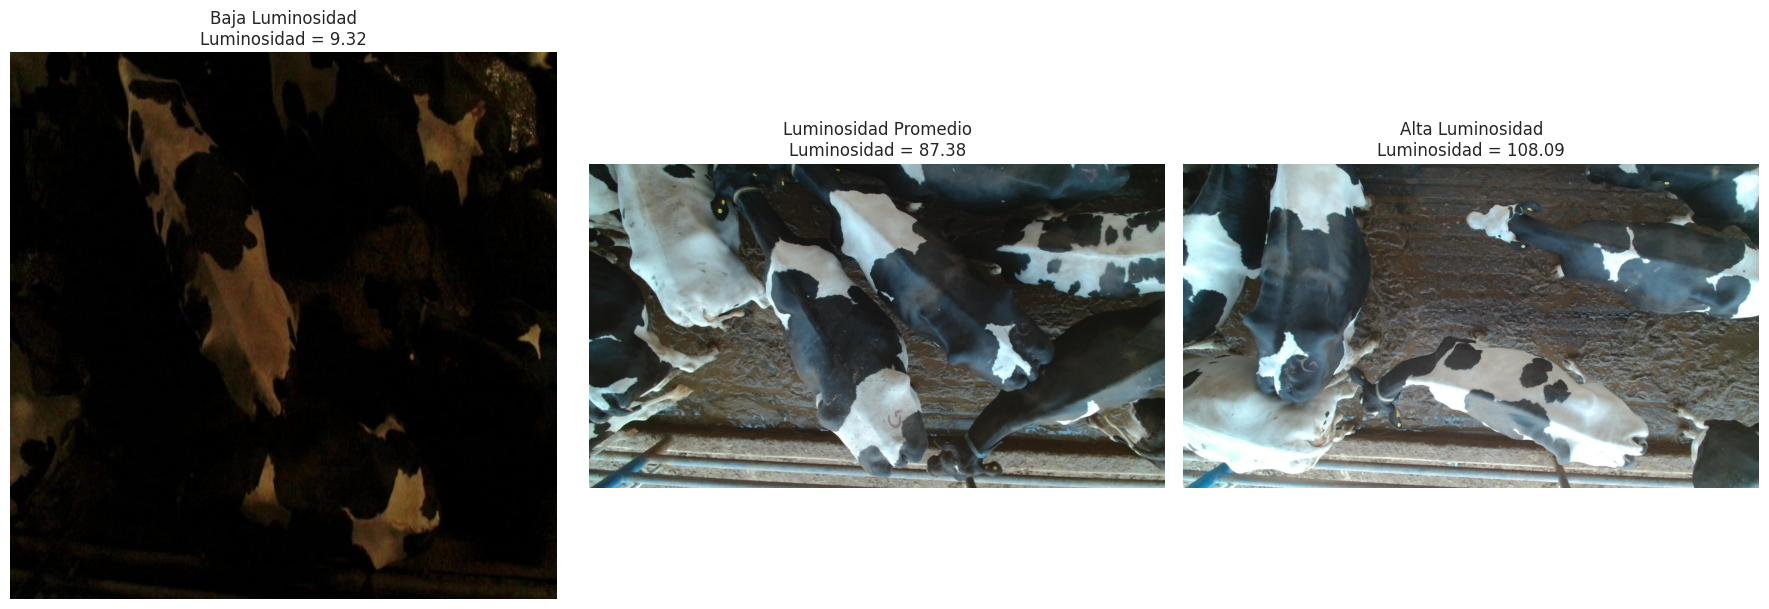

In [37]:
# Crear una figura con 3 subplots
plt.figure(figsize=(18, 6))

# Imagen de baja luminosidad
plt.subplot(1, 3, 1)
if image_low_pil:
    plt.imshow(image_low_pil)
    plt.title(f'Baja Luminosidad\nLuminosidad = {image_low["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de luminosidad promedio
plt.subplot(1, 3, 2)
if image_average_pil:
    plt.imshow(image_average_pil)
    plt.title(f'Luminosidad Promedio\nLuminosidad = {image_average["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de alta luminosidad
plt.subplot(1, 3, 3)
if image_high_pil:
    plt.imshow(image_high_pil)
    plt.title(f'Alta Luminosidad\nLuminosidad = {image_high["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

plt.tight_layout()
plt.show()